# Car Decor Sales Forecasting - AndroidHeadunits

###### Importing Libraries

In [2]:
pip install mysql-connector-python

     |████████████████████████████████| 30.9 MB 82 kB/s 


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
from math import sqrt

# Connecting Python to MySQL for fetching data 
import mysql.connector

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


###### MySQL Connection to fetch data

In [4]:
try:
    connection = mysql.connector.connect(host='localhost',
                                        database='car_decors',
                                         user='root',
                                         password='***********')

    sql_select_Query = "SELECT * FROM decorsales"
    cursor = connection.cursor()
    cursor.execute(sql_select_Query)
    columns = len(cursor.description)
    columns = [i[0] for i in cursor.description]
    print(columns)

    # get all records
    records = cursor.fetchall()
    print("Total number of rows in table: ", cursor.rowcount)

except mysql.connector.Error as e:
    print("Error reading data from MySQL table", e)

Error reading data from MySQL table 2003 (HY000): Can't connect to MySQL server on 'localhost:3306' (99)


### Data Cleaning and Exploratory Data Analysis

###### Converting fetched records to Pandas dataframe

In [ ]:
records = np.array(records)
records = records[:,0:25]
decor_sales=pd.DataFrame(records,columns=columns)

###### Type Casting Date and other features

In [ ]:
decor_sales.dtypes
decor_sales.Date = pd.to_datetime(decor_sales.Date)
decor_sales.iloc[:,1:] = decor_sales.iloc[:,1:].astype("int32")
decor_sales.dtypes

Date                 datetime64[ns]
AndroidHeadunits              int32
Speakers                      int32
Cameras                       int32
LeatherSeatCovers             int32
GLSteeringCovers              int32
7DMatts                       int32
3DMatts                       int32
Horns                         int32
Armrests                      int32
LedHeadlights                 int32
AlloyWheels                   int32
Spoilers                      int32
FancyGrills                   int32
ChromeAccessories             int32
RearGuards                    int32
SideBeading                   int32
BumperProtectors              int32
DoorGuards                    int32
DoorVisors                    int32
Sunfilm                       int32
Perfumes                      int32
LedFogLamps                   int32
Denting                       int32
Painting                      int32
dtype: object

###### Creating Subset of Decor Sales Dataset and resampling Monthly Time Series

In [ ]:
df = decor_sales
df = df.set_index('Date')
df = df.resample("MS").sum()

###### Data Visualization

In [ ]:
plt.rc("figure", figsize=(16,8))
sns.set_style('darkgrid')

###### Rolling statistics to observe variation in mean and standard deviation.

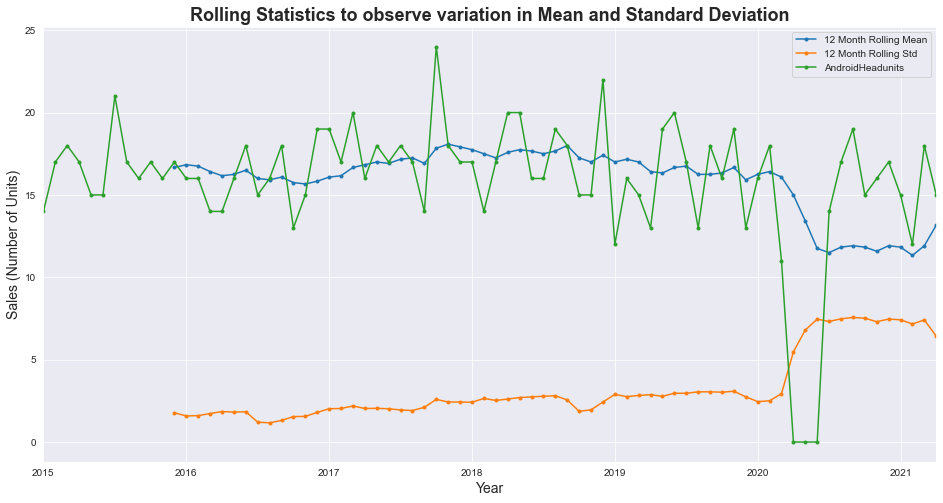

In [ ]:
timeseries = df ['AndroidHeadunits']
timeseries.rolling(12).mean().plot(label='12 Month Rolling Mean', marker='.')
timeseries.rolling(12).std().plot(label='12 Month Rolling Std', marker='.')
timeseries.plot(marker='.')
plt.title('Rolling Statistics to observe variation in Mean and Standard Deviation', fontsize = 18, fontweight = 'bold')
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Sales (Number of Units)', fontsize = 14)
plt.legend()

###### Checking Seasonalty and Trend components for the feature

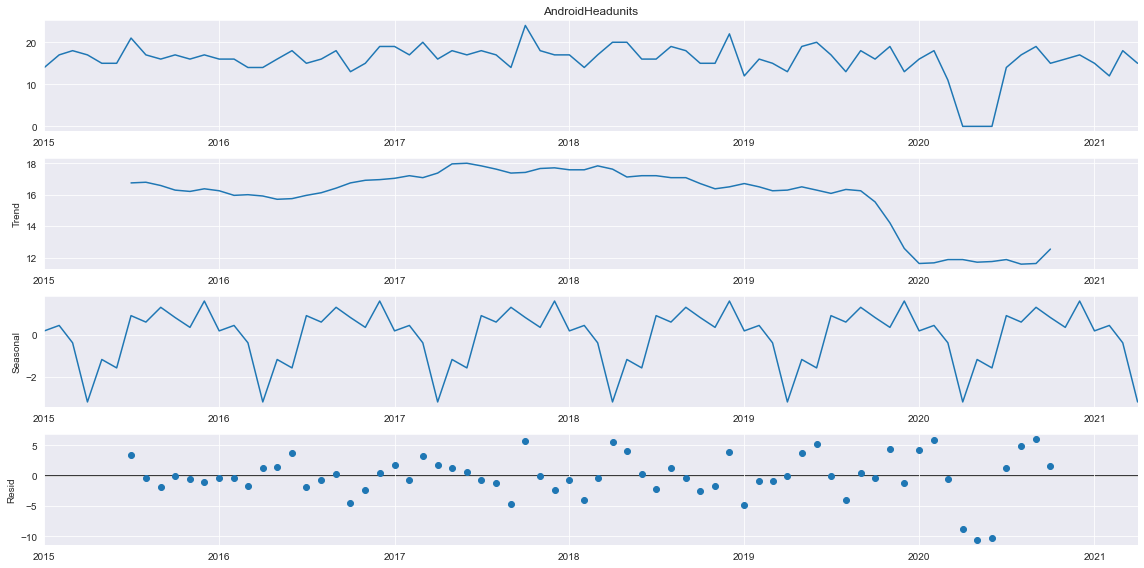

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
add = seasonal_decompose(df["AndroidHeadunits"],model="additive",period=12)
add.plot();

##### Checking for Data Stationarity using Augmented Dickey-Fuller Test

In [ ]:
from statsmodels.tsa.stattools import adfuller

def check_adf(time_series):
    test_result = adfuller(df['AndroidHeadunits'])
    print ('ADF Test:')
    labels = ['ADF Statistic','p-value','No. of Lags Used','Number of Observations Used']

    for value,label in zip(test_result,labels):
        print (label+': '+str(value)+str("\n"))
        if test_result [1] <= 0.05:
            print ("Reject null hypothesis; Data is stationary")
        else:
            print ("Fail to reject H0; Data is non-stationary")

In [ ]:
check_adf(df['AndroidHeadunits'])

ADF Test:
ADF Statistic: -4.867404208941872

Reject null hypothesis; Data is stationary
p-value: 4.0343859990134705e-05

Reject null hypothesis; Data is stationary
No. of Lags Used: 0

Reject null hypothesis; Data is stationary
Number of Observations Used: 75

Reject null hypothesis; Data is stationary


# Adfuller test Results for all variables

In [ ]:
from statsmodels.tsa.stattools import adfuller
def adfuller_parameter(x):
    P = []
    columns = []
    used_lag = []
    for i in x.columns:
        test_stats,p,used_lags,nobs,critical_value,ic_best = adfuller(x[i])
        columns.append(i)
        P.append(p)
        used_lag.append(used_lags)
    return pd.DataFrame({"COLUMNS":columns,"P_VALUE":P,"MAX_USED_LAG":used_lag})

adfuller_parameter(df)

,COLUMNS,P_VALUE,MAX_USED_LAG
0,AndroidHeadunits,4.034386e-05,0
1,Speakers,6.422908e-06,0
2,Cameras,2.597276e-07,0
3,LeatherSeatCovers,1.187287e-03,2
4,GLSteeringCovers,3.457467e-05,0
5,7DMatts,1.499884e-04,0
6,3DMatts,5.435222e-04,2
7,Horns,2.230973e-03,2
8,Armrests,4.661329e-10,0
9,LedHeadlights,2.872973e-05,2


##### Hyper-parameter Tuning # Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots

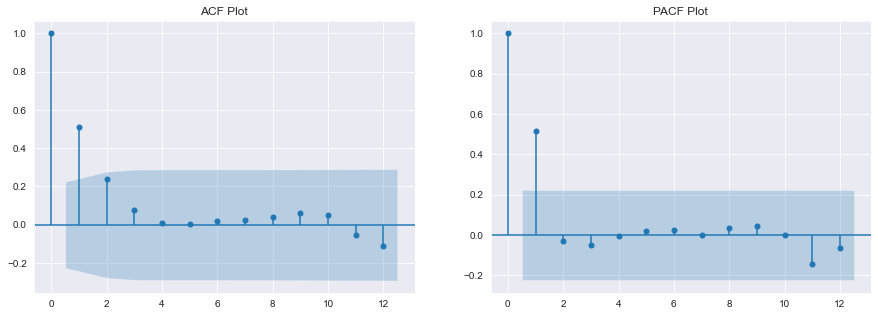

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

fig, ax = plt.subplots(1,2, figsize=(15,5))
sm.graphics.tsa.plot_acf(df["AndroidHeadunits"], lags=12, title = 'ACF Plot', ax=ax[0])
sm.graphics.tsa.plot_pacf(df["AndroidHeadunits"], lags=12, title = 'PACF Plot',ax=ax[1])
plt.show()

### Model Building - SARIMA Model ( Seasonal ARIMA Model )

###### Train Test Split

In [ ]:
train_df = df["AndroidHeadunits"].iloc[0:int(len(df)*.95)] #train model with approx 95% data
test_df = df["AndroidHeadunits"].iloc[int(len(train_df)):] #test model with 5% data

print("Train_df : ",len(train_df))
print("Test_df : ",len(test_df))

Train_df :  72
Test_df :  4


###### User Defined Function to calculate the MAPE value 

In [ ]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

###### Automated Hyperparameter tuning

In [ ]:
 import itertools as i 
p = range(0,3) 
d = range(0,2)
q = range(0,3)

pdq_combo = list(i.product(p,d,q)) #this will all combination of p,d,q throgh a tuple 

error = []
aic_sarima = []
order_arima = []
order_sarima = []
seasonality = 12
for pdq in pdq_combo:
    for PDQ in pdq_combo:
        try:
            SEASONAL_ORDER = list(PDQ)
            SEASONAL_ORDER.append(seasonality)
            model = sm.tsa.SARIMAX(train_df,order=(pdq),seasonal_order=tuple(SEASONAL_ORDER))
            result = model.fit(disp=0)
            pred = result.predict(start=len(train_df),end=len(df)-1)
            eror = mape(test_df,pred)
            aic_sarima.append(result.aic)
            order_arima.append(pdq)
            order_sarima.append(tuple(SEASONAL_ORDER))
            error.append(eror)
        except:
            continue

C:\Users\sriva\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:865: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
C:\Users\sriva\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\sriva\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:977: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [ ]:
# Creating a dataframe of seasonality orders and errors 
df_error = pd.DataFrame({"arima_order":order_arima,"sarima_order": order_sarima,"error":error,"aic":aic_sarima})
df_error = df_error.sort_values(by="error",ascending = True)
df_error.reset_index(inplace=True,drop=True)

In [ ]:
## best parameter selection
p_d_q = df_error.iloc[0,0] #choosing best parameter for arima order
P_D_Q = df_error.iloc[0,1] #choosing best parameter for seasonal  order

In [ ]:
## best parameter selection
print("Best p_d_q parameter : ", p_d_q)
print("Best P_D_Q parameter : ", P_D_Q)

Best p_d_q parameter :  (0, 0, 2)
Best P_D_Q parameter :  (2, 0, 1, 12)


###### Model with best parameter

In [ ]:
sarima_model = sm.tsa.SARIMAX(train_df, order=(p_d_q), seasonal_order=(P_D_Q))
sarima_results = sarima_model.fit(disp = 0)
sarima_pred = sarima_results.predict(start=test_df.index[0],end=test_df.index[-1])
sarima_pred_large = sarima_results.predict(start=75,end=86,dynamic=True)

C:\Users\sriva\anaconda3\lib\site-packages\statsmodels\tsa\statespace\kalman_filter.py:2290: ValueWarning: Dynamic prediction specified to begin during out-of-sample forecasting period, and so has no effect.
  warn('Dynamic prediction specified to begin during'


                                      SARIMAX Results                                       
Dep. Variable:                     AndroidHeadunits   No. Observations:                   72
Model:             SARIMAX(0, 0, 2)x(2, 0, [1], 12)   Log Likelihood                -214.410
Date:                              Mon, 23 Aug 2021   AIC                            440.820
Time:                                      21:10:58   BIC                            454.480
Sample:                                  01-01-2015   HQIC                           446.258
                                       - 12-01-2020                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6508      0.097      6.679      0.000       0.460       0.842
ma.L2          0.37

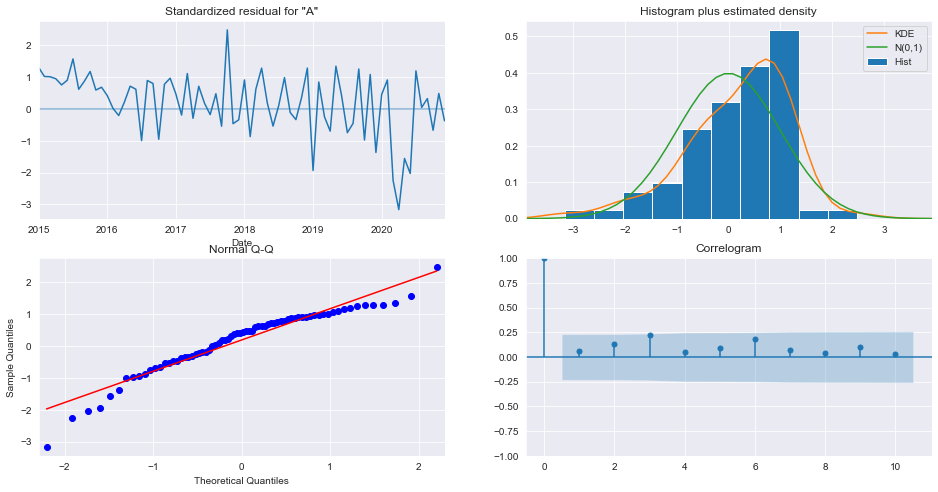

In [ ]:
print(sarima_results.summary())
sarima_diagnostics = sarima_results.plot_diagnostics(figsize=(16,8))

In [ ]:
# Predicted values
# Point estimation
sarima_prediction = sarima_results.get_prediction(start = test_df.index[0], end = test_df.index[-1], dynamic = True, full_results = True)
sarima_point_estimation = sarima_prediction.predicted_mean
sarima_point_estimation

2021-01-01    14.847491
2021-02-01    14.873490
2021-03-01    16.383201
2021-04-01    15.922858
Freq: MS, Name: predicted_mean, dtype: float64

In [ ]:
#Checking MAPE
mape(test_df, sarima_point_estimation)

10.024270335369097

In [ ]:
# At 95% confidence interval
sarima_pred_range = sarima_prediction.conf_int(alpha = 0.05)
sarima_pred_range

,lower AndroidHeadunits,upper AndroidHeadunits
2021-01-01,7.464132,22.230851
2021-02-01,6.090977,23.656004
2021-03-01,7.191849,25.574553
2021-04-01,6.731506,25.114210


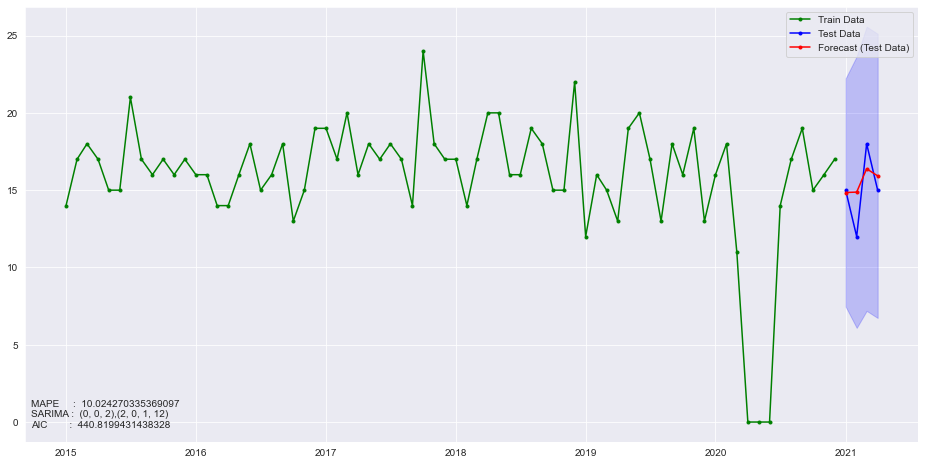

In [ ]:
# Ploting Sarima Prediction
plt.plot(train_df,color="g",label="Train Data", marker='.')
plt.plot(test_df,color="b",label="Test Data", marker='.')
plt.plot(sarima_point_estimation,color="r",label="Forecast (Test Data)", marker='.')
plt.figtext(0.13, 0.15, '\nMAPE     :  {} \nSARIMA :  {},{} \nAIC        :  {}'.format(mape(test_df, sarima_point_estimation), p_d_q, P_D_Q, sarima_results.aic, fontsize = 11))
plt.fill_between(sarima_pred_range.index,sarima_pred_range.iloc[:,0],sarima_pred_range.iloc[:,1],color='b',alpha=.2)
plt.legend(loc="upper right")

### Holt Winters Exponential Smoothing with Additive Seasonality and Additive Trend

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing # 

hwe_model_add_add = ExponentialSmoothing(train_df, seasonal ="add", trend = "add", seasonal_periods = 12).fit()
pred_hwe_add_add = hwe_model_add_add.predict(start = test_df.index[0], end = test_df.index[-1])

C:\Users\sriva\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [ ]:
pred_hwe_add_add

2021-01-01    15.055045
2021-02-01    15.721717
2021-03-01    15.221699
2021-04-01    12.721668
Freq: MS, dtype: float64

###### Plotting Holt Winters Model 

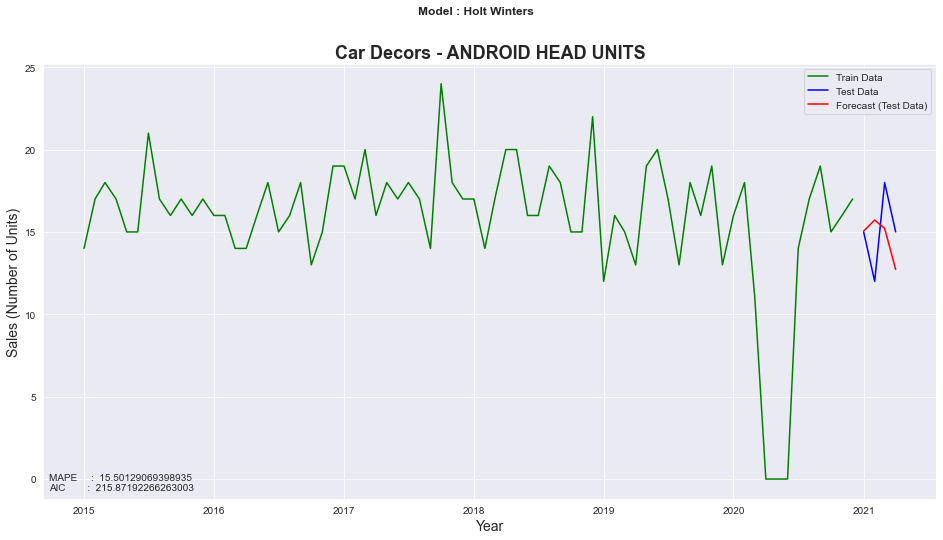

In [ ]:
plt.plot(train_df,color="g",label="Train Data")
plt.plot(test_df,color="b",label="Test Data")
plt.plot(pred_hwe_add_add,color="r",label="Forecast (Test Data)")
plt.suptitle('Model : Holt Winters', fontsize = 12, fontweight = 'bold')
plt.title('Car Decors - ANDROID HEAD UNITS', fontsize = 18, fontweight = 'bold')
plt.figtext(0.13, 0.14, '\nMAPE     :  {} \nAIC        :  {}'.format(mape(test_df, pred_hwe_add_add), hwe_model_add_add.aic))
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Sales (Number of Units)', fontsize = 14)
plt.legend(loc="best")

In [ ]:
mape(test_df, pred_hwe_add_add) 

15.50129069398935

### FB Prophet Model

In [ ]:
# Loading Libraries
from fbprophet import Prophet
from fbprophet.plot import plot_plotly

df1 = decor_sales
df1 = df1.set_index('Date')
df1 = df1.resample("MS").sum()
df1.reset_index(inplace=True)

In [ ]:
train_df1 = df1[["Date","AndroidHeadunits"]].iloc[0:int(len(df1)*.95)] #train model with approx 95% data
test_df1 = df1[["Date","AndroidHeadunits"]].iloc[int(len(train_df1)):] #test model with 5% data

print("Train : ",len(train_df1))
print("Test : ",len(test_df1))

Train :  72
Test :  4


In [ ]:
train_df1.columns = ["ds","y"]
test_df1.columns = ["ds","y"]

In [ ]:
# Fitting the Model
prophet_model = Prophet().fit(train_df1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [ ]:
# Define the period for which we want a prediction
future = list()
for i in range(1, 5):
	date = '2021-%02d' % i
	future.append([date])
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= pd.to_datetime(future['ds'])
future 

,ds
0,2021-01-01
1,2021-02-01
2,2021-03-01
3,2021-04-01


In [ ]:
forecast = prophet_model.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']])

          ds       yhat  yhat_lower  yhat_upper
0 2021-01-01  14.412619    9.756169   18.913280
1 2021-02-01  14.571877   10.149097   19.224945
2 2021-03-01  13.744416    9.284715   18.563682
3 2021-04-01  10.697385    6.238702   15.446668


In [ ]:
test_df1=test_df1.set_index("ds")
train_df1 = train_df1.set_index("ds")
forecast=forecast.set_index("ds")

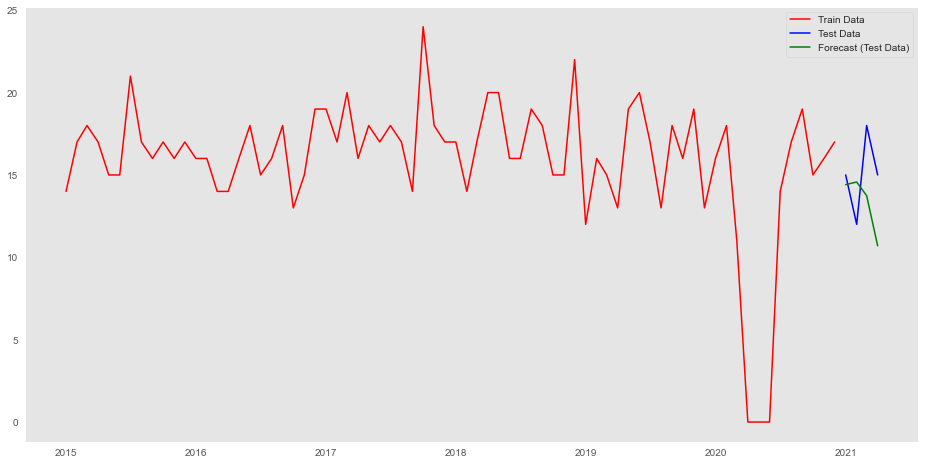

In [ ]:
plt.style.use("ggplot")
plt.plot(train_df1['y'],color="r",label="Train Data")
plt.plot(test_df1['y'],color="b",label="Test Data")
plt.plot(forecast["yhat"],color="g",label="Forecast (Test Data)")
plt.grid( linestyle='-', linewidth=2)
plt.legend(loc="best")

In [ ]:
# MAPE
mape(test_df1['y'], forecast['yhat'])

19.418604276669743

In [ ]:
#RMSE
sqrt(mean_squared_error(test_df1['y'], forecast['yhat'].tail(4)))

3.3008355622682655

### Auto Time Series Model

In [ ]:
from auto_ts import auto_timeseries

Imported auto_timeseries version:0.0.36. Call by using:
model = auto_timeseries(score_type='rmse',
                time_interval='M',
                non_seasonal_pdq=None, seasonality=False, seasonal_period=12,
                model_type=['best'],
                verbose=2)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



In [ ]:
train_df2 = train_df1
test_df2 = test_df1

In [ ]:
ts_model = auto_timeseries( score_type='rmse', time_interval='MS', non_seasonal_pdq=(12,12,12), seasonality=True, seasonal_period=12, model_type="best", verbose=2)

Start of Fit.....
Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Results of Augmented Dickey-Fuller Test:
+-----------------------------+------------------------------+
|                             | Dickey-Fuller Augmented Test |
+-----------------------------+------------------------------+
|        Test Statistic       |       -4.6306482250272       |
|           p-value           |    0.00011337124287631655    |
|          #Lags Used         |             0.0              |
| Number of Observations Used |             71.0             |
|     Critical Value (1%)     |      -3.526004646825607      |
|     Critical Value (5%)     |     -2.9032002348069774      |
|     Critical Value (10%)    |     -2.5889948363419957      |
+-----------------------------+------------------------------+
 this series is stationary
    Target variable given as = y
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts_column:

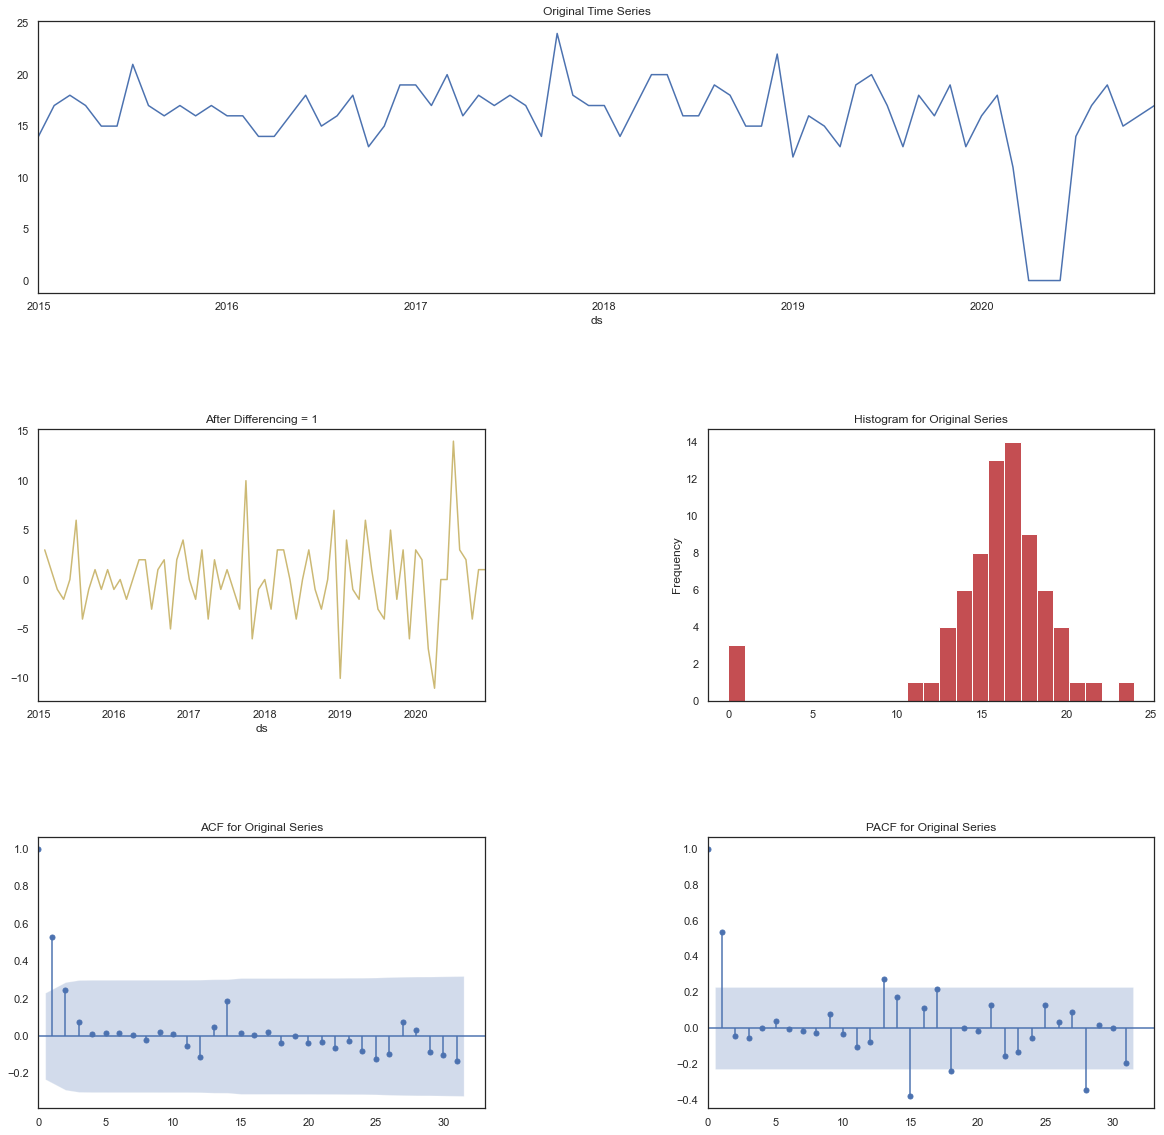

Time Interval is given as MS
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
    Fit-Predict data (shape=(72, 2)) with Confidence Interval = 0.95...
  Starting Prophet Fit
       Adding monthly seasonality to Prophet with period=12, fourier_order=12 and prior_scale=0.10
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 47 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 4.20
    Std Deviation of actuals = 3.50
    Normalized RMSE = 120%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 52 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 3.59
    Std Deviation of actuals = 2.42
    Normalized RMSE = 149%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 57 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 3.30
    Std Deviation of 

 ARIMA(0,0,0)(0,0,1)[12]             : AIC=inf, Time=0.23 sec

Best model:  ARIMA(0,0,0)(0,0,1)[12] intercept
Total fit time: 6.041 seconds

Best model is a Seasonal SARIMAX(0,0,0)*(0,0,1,12), aic = 275.395
Static Forecasts:
    RMSE = 12.98
    Std Deviation of Actuals = 6.20
    Normalized RMSE = 209.4%

Fold Number: 5 --> Train Shape: 67 Test Shape: 5

    Finding the best parameters using AutoArima:
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=385.016, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=362.002, Time=0.41 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=366.856, Time=0.12 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=567.099, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=364.721, Time=0.13 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=362.118, Time=0.66 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=362.425, Time=0.63 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=360.443, Time=0.41 sec
 ARIMA(1,0,0)(0,0,2)[1

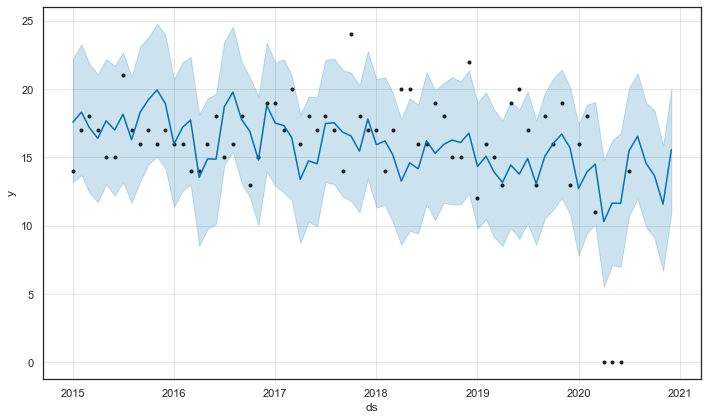

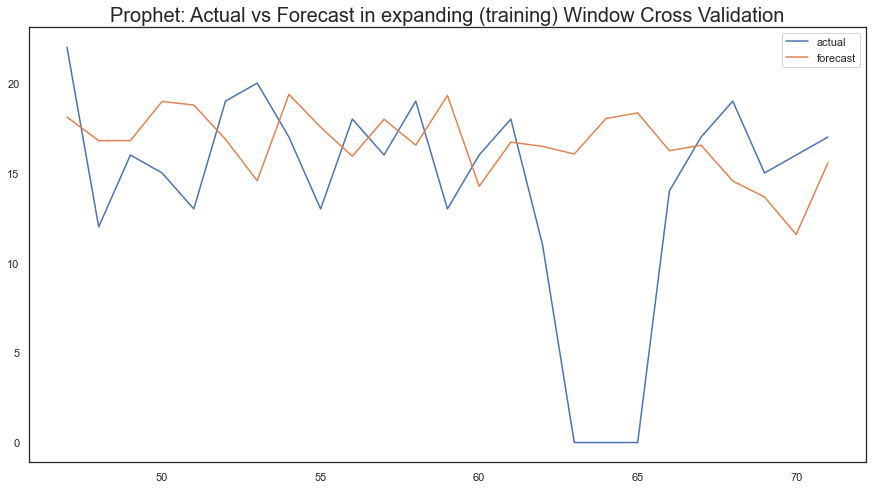

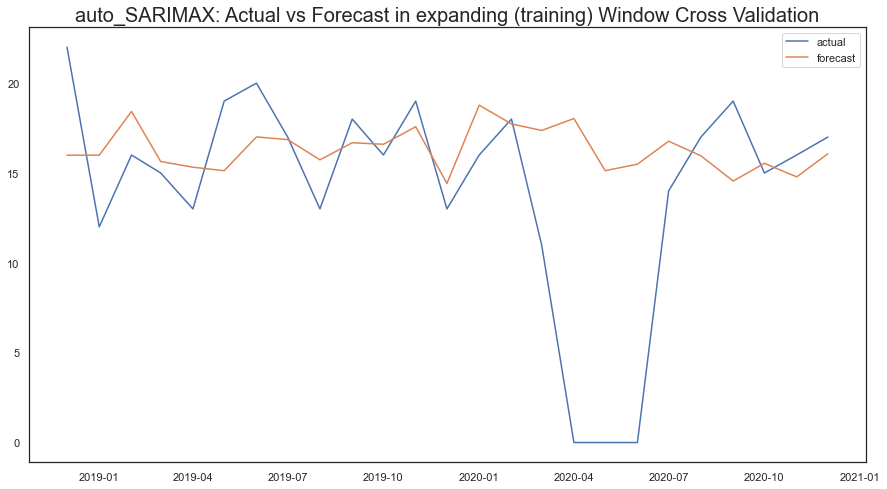

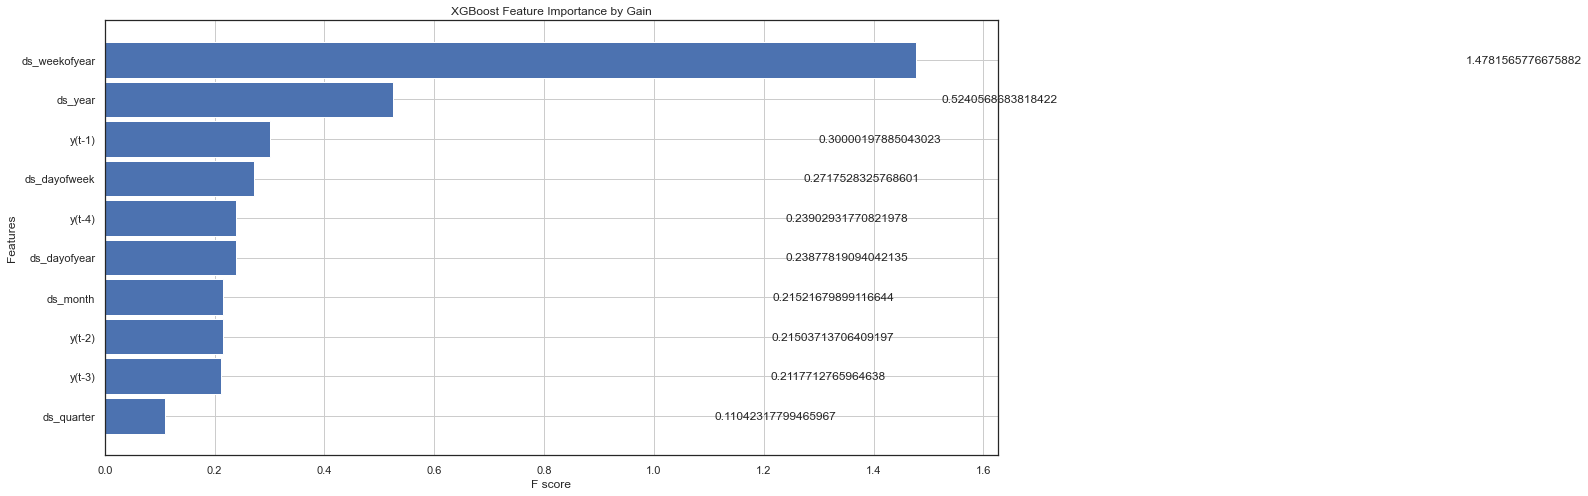

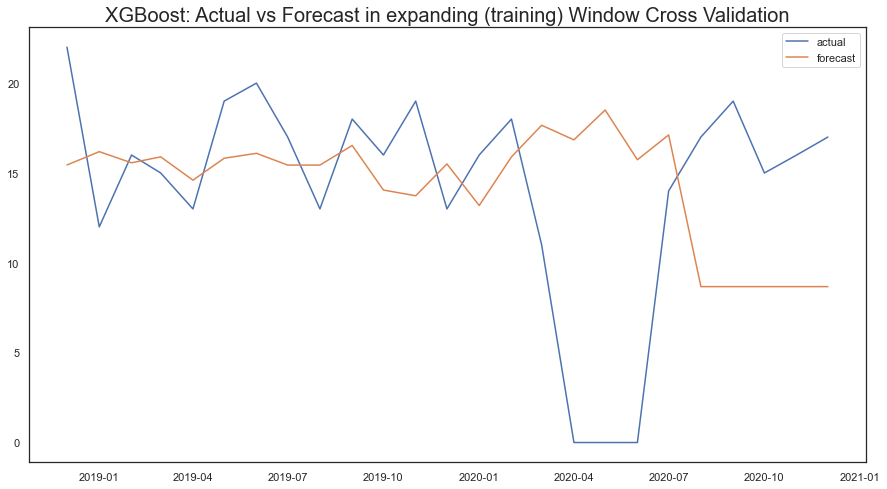

In [ ]:
ts_model.fit(traindata= train_df2, ts_column="ds", target="y")

In [ ]:
ts_model.get_leaderboard()

,name,rmse
1,auto_SARIMAX,4.570271
0,Prophet,5.570851
3,ML,6.255732
2,VAR,inf


<AxesSubplot:xlabel='Model', ylabel='CV Scores'>

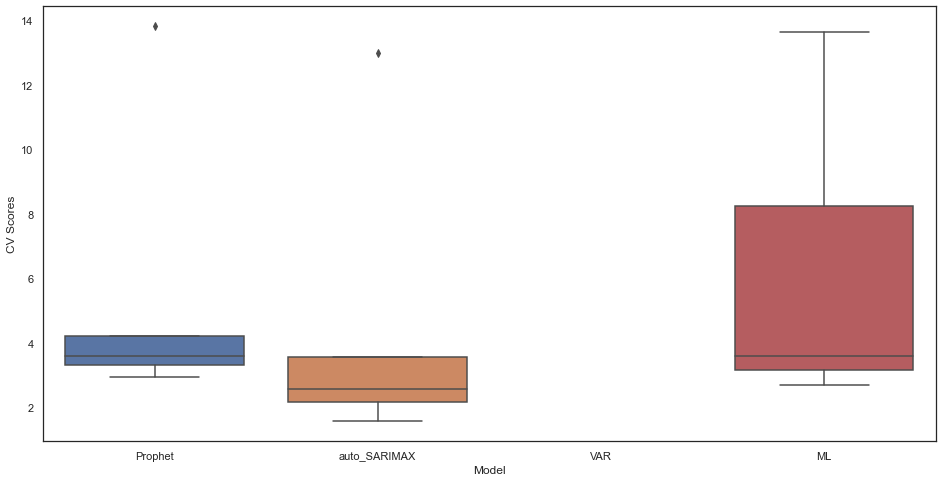

In [ ]:
ts_model.plot_cv_scores()

In [ ]:
future_predictions = ts_model.predict(test_df2, model='best')
future_predictions

y,yhat,mean_se,mean_ci_lower,mean_ci_upper
2021-01-01,15.798186,3.430338,9.074846,22.521526
2021-02-01,13.752366,3.845500,6.215324,21.289408
2021-03-01,15.970252,3.945059,8.238078,23.702425
2021-04-01,20.282537,3.970220,12.501049,28.064025


In [ ]:
# define the period for which we want a prediction
ts_future = list()
for i in range(1, 5):
	date = '2021-%02d' % i
	ts_future.append([date])
ts_future = pd.DataFrame(ts_future)
ts_future.columns = ['ds']
ts_future['ds']= pd.to_datetime(ts_future['ds'])

In [ ]:
ts_model.predict(ts_future)

y,yhat,mean_se,mean_ci_lower,mean_ci_upper
2021-01-01,15.798186,3.430338,9.074846,22.521526
2021-02-01,13.752366,3.845500,6.215324,21.289408
2021-03-01,15.970252,3.945059,8.238078,23.702425
2021-04-01,20.282537,3.970220,12.501049,28.064025


In [ ]:
mape(test_df2["y"],future_predictions["yhat"])

16.604394739829008

### Models Evaluation

In [ ]:
from sklearn.metrics import mean_squared_error as mse
print("\nSARIMA Trend          :  ", p_d_q)
print("SARIMA Seasonal Order :  ", P_D_Q)
print("SARIMA AIC            :  ", sarima_results.aic)
print("SARIMA RMSE           :  ", np.sqrt(mse(test_df,sarima_point_estimation)))
print("SARIMA MAPE           :  ", mape(test_df, sarima_point_estimation))
print("\nHolt Winters AIC      :  ", hwe_model_add_add.aic)
print("Holt Winters RMSE     :  ", np.sqrt(mse(test_df,pred_hwe_add_add)))
print("Holt Winters MAPE     :  ", mape(test_df, pred_hwe_add_add))
print("\nFB Prophet RMSE       :  ", sqrt(mean_squared_error(test_df1['y'], forecast['yhat'])))
print("FB Prophet MAPE       :  ", mape(test_df1['y'], forecast['yhat']))
print("\nAuto Time Series: \n  ", ts_model.get_leaderboard())
print("Auto Time Series MAPE       :  ", mape(test_df2["y"],future_predictions["yhat"]))


SARIMA Trend          :   (2, 0, 1)
SARIMA Seasonal Order :   (1, 1, 1, 12)
SARIMA AIC            :   355.3353441058182
SARIMA RMSE           :   1.7395551990641358
SARIMA MAPE           :   10.067540891773998

Holt Winters AIC      :   215.87192266403028
Holt Winters RMSE     :   2.586696880826467
Holt Winters MAPE     :   15.501293343307838

FB Prophet RMSE       :   3.3008355622682655
FB Prophet MAPE       :   19.418604276669743

Auto Time Series: 
              name      rmse
1  auto_SARIMAX  4.570271
0       Prophet  5.570851
3            ML  6.255732
2           VAR       inf
Auto Time Series MAPE       :   16.604394739829008


In [ ]:
sarima = mape(test_df, sarima_point_estimation)
hwinters = mape(test_df, pred_hwe_add_add)
fbprophet = mape(test_df1['y'], forecast['yhat'])
autots = mape(test_df2["y"],future_predictions["yhat"])

mape_data = {'models':['SARIMA','HOLTWINTERS','FB_PROPHET','AUTO_TS'], 'name':['sarima_model', 'hwe_model_add_add','prophet_model','ts_model'],'mape':[sarima, hwinters, fbprophet, autots]}
mape_error = pd.DataFrame(mape_data)
mape_error = mape_error.sort_values(by="mape",ascending = True)
mape_error.reset_index(inplace=True,drop=True)
#best_model = mape_error.iloc[0,0]
print('\033[1m'+"Best Model with lowest MAPE : ", mape_error.iloc[0,0] + " ( " + mape_error.iloc[0,1] + " ) " + '\033[0m')
print("\nMAPE ERRORS :\n\n", mape_error)

Best Model with lowest MAPE :  SARIMA ( sarima_model ) 

MAPE ERRORS :

         models               name       mape
0       SARIMA       sarima_model  10.067541
1  HOLTWINTERS  hwe_model_add_add  15.501293
2      AUTO_TS           ts_model  16.604395
3   FB_PROPHET      prophet_model  19.418604


##### Saving Best Model

In [ ]:
import pickle
filename = 'sarima_model_ahu.pkl'
pickle.dump(sarima_model, open(filename, 'wb'))

######  Testing saved Model for prediction

In [ ]:
####### Model summary and diagnstics plot #######
with open(filename, "rb") as file:
    load_model = pickle.load(file)
    
result = load_model.fit()
#print(result.summary())
#diagnostics = result.plot_diagnostics(figsize=(16,8))

In [ ]:
pred = result.get_prediction(start = 76, end = 87, dynamic = False)

# Point estimation
prediction = pred.predicted_mean
prediction = round(prediction)

In [ ]:
# Ploting final Sarima Prediction
plt.plot(df['AndroidHeadunits'],color="g",label="Actual", marker='.')
plt.plot(prediction,color="r",label="Forecast", marker='.')
plt.suptitle('Model : SARIMA', fontsize = 12, fontweight = 'bold')
plt.title('Car Decors - AndroidHeadUnits', fontsize = 18, fontweight = 'bold')
plt.figtext(0.13, 0.14, '\nMAPE     :  {} \nAIC        :  {}'.format(mape(test_df, sarima_point_estimation), sarima_results.aic))
plt.xlabel('Year', fontsize = 14)
plt.ylabel('Sales (Number of Units)', fontsize = 14)
plt.legend(loc="best")

### Closing connection to MySQL and clearing variables from memory.

In [ ]:
#if connection.is_connected():
#    connection.close()
#    cursor.close()
#    print("MySQL connection is closed")

# Clear all variables from memory
#globals().clear()

#####################################################################